In [14]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

In [15]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

# Shape(m, pixel rows, pixel cols) == (6000, 28, 28)
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# Normalizing pixel values from [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [16]:
def layer_init(L_IN, L_OUT):
  # uniform dist
  ret = np.random.uniform(-1., 1., size=(L_IN,L_OUT))/np.sqrt(L_IN*L_OUT)
  return ret.astype(np.float32)


In [17]:
def return_labeled(y, num_labels):
    '''returns (m, num_labels) matrix of correct answers'''
    out = np.zeros((len(y), num_labels), np.float32)
    for example in range(0, len(y)):
        correct_answer = int(y[example])
        out[example, correct_answer] = 1
    return out

In [18]:
def ReLU(x):
    ''' 0: if x < 0
        x: otherwise
    '''
    return x * (x > 0).astype(np.float32)

def dx_ReLU(x):
    '''0: if x < 0
       1: otherwise
    '''
    return 1. * (x > 0).astype(np.float32)

def log_sum_exp(x):
    '''normalizing'''
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

In [45]:
def propogate(X,y):
    ''' handles forward and backwards propogation
    X size     : (m, input_layer_size)
    theta1 size: (input_layer_size, hidden_layer_size)
    theta2 size: (hidden_layer_size, num_labels) '''
    labels = return_labeled(y, num_labels) # (m, num_labels) of correct outputs
    
    # Forward Propogate:
    z2 = X.dot(theta1)                              # calculating layer 2 before activation
    a2_relu = ReLU(z2)                              # Activation of hidden layer using ReLU
    z3 = a2_relu.dot(theta2)                        # calculating layer 3
    log_sm = z3 - log_sum_exp(z3).reshape(-1,1)     # log sum normalizing z3: LOG SOFTMAX 
    J = (-labels * log_sm).mean(axis=1)             # Calculating cost with log probs to normalize and avoid overflows
    
    # Back propogation
    d_out = -labels / len(y)                        # Replace 1 in each row of labeld with (-1/m), else 0
    # Taking derivative of log soft max: https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_log_sm = d_out - np.exp(log_sm)*d_out.sum(axis=1).reshape((-1, 1))
    

    grad2 = a2_relu.T.dot(dx_log_sm)
    dx_relu = dx_log_sm.dot(theta2.T)
    
    # derivative of relu
    dx_theta1 = dx_ReLU(a2_relu) * dx_relu
    # derivative of theta1
    grad1 = X.T.dot(dx_theta1)
      
    return J, z3, grad1, grad2
    

In [46]:
# Architecture
input_layer_size = 784   # (28,28) pixels
hidden_layer_size = 120  # Hidden layer nodes
num_labels = 10          # digits [0-9] = 10 total

np.random.seed(1420)
theta1 = layer_init(input_layer_size, hidden_layer_size)  # (input_layer_size,hidden_layer_size)
theta2 = layer_init(hidden_layer_size, num_labels)        # (hidden_layer_size, num_labels)

learning_rate = 0.1
batch_size = 120
epochs = 1000

costs, accuracies = [], []

loss 0.02 accuracy 0.91: 100%|██████████| 1000/1000 [00:02<00:00, 480.83it/s]


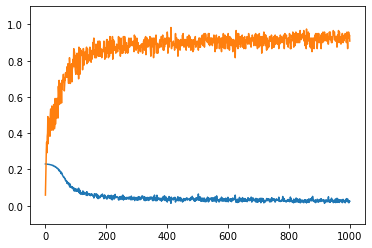

In [47]:


# Training logic
for i in (t := trange(epochs)):
    
    # Grabbing a random array of size batch size, indexes [0-m], m := # examples
    samples = np.random.randint(0, len(y_train), size=(batch_size))
    X = X_train[samples].reshape(-1, 28 * 28)   # (m, pixel rows, pixel cols) -> (m, pixels)
    y = y_train[samples]                        # (m, ) vector of output MIGHT {NEED TO RESHAPE}
    
    cost, h, gradient1, gradient2 = propogate(X,y) # fwd/back prop. returns (cost, predictions, theta1 grad, theta2 grad)
    
    prediction = np.argmax(h, axis=1)
    accuracy = (prediction == y).mean()
    
    # Stoich grad descent
    theta1 = theta1 - (learning_rate * gradient1)
    theta2 = theta2 - (learning_rate * gradient2)
    
    
    cost = cost.mean()
    costs.append(cost)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (cost, accuracy))


# Displaying cost and accuracy over iterations
plt.ylim(-0.1, 1.1)
plt.plot(costs)
plt.plot(accuracies)


(120, 10)
